# Importing Libraries

In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

- The link where the data was downloaded is: http://insideairbnb.com/get-the-data/. 
- This dataset is specifically the listings in NYC. 
- The data columns can be explained when clicking on this link https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing. 
- Data used in this project was scraped on December 15, 2022.

# Loading and Preparing Datasets

In [20]:
# Dropping all of the columns which we will not use
# listingsNYC= listingsNYC.drop(['last_review','license','latitude','longitude','host_name'], axis=1)
listingsNYC = pd.read_csv('listings.csv', dtype=object)
# Dropping all rows with any 'Nan' values in them
# listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64'}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC['neighbourhood'].unique().shape[0]
listingsNYC.describe()
listingsNYC['annual_revenue'] = (365 - listingsNYC['availability_365']) *  listingsNYC['price']
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])
listingsNYC.loc[:,'log_pps']=np.log(listingsNYC['pps'])
# listingsNYC['price_bin'] = pd.cut(listingsNYC['price'], bins=range(0, 111, 10), right=False, labels=range(0, 110, 10))

### Making the final df

In [21]:
# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
df = listingsNYC[(listingsNYC['price']<2000) & (listingsNYC['price']>20) & (listingsNYC['minimum_nights'] < 30)]
df['price_bin'] = pd.cut(df['price'], bins=range(0, 2001, 20), right=False, labels=range(0, 2000, 20))

### Checking the Final DF

In [22]:
# check for outliers 
describe_df = df.describe()
describe_df

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps,annual_revenue,log_price,log_pps
count,21690.000000,21690.000000,21690.000000,18659.000000,21690.000000,21690.000000,21690.000000,21690.000000,21690.000000,21690.000000,21690.000000
mean,221.639696,3.418442,38.833287,1.959596,8.148041,171.741263,14.499216,703.313324,40219.488751,5.079702,5.933164
std,229.568948,4.171019,69.240917,2.265433,25.637217,138.881675,23.650862,1200.655745,55265.613054,0.755109,1.068130
min,22.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,28.000000,0.000000,3.091042,3.332205
25%,92.000000,1.000000,2.000000,0.560000,1.000000,32.000000,1.000000,175.000000,5867.500000,4.521789,5.164786
50%,150.000000,2.000000,13.000000,1.450000,2.000000,156.000000,7.000000,368.000000,25011.000000,5.010635,5.908083
75%,255.000000,4.000000,44.000000,2.820000,4.000000,333.000000,22.000000,750.000000,52045.500000,5.541264,6.620073
max,1999.000000,29.000000,1666.000000,102.980000,200.000000,365.000000,992.000000,31668.000000,729635.000000,7.600402,10.363062


# Visualizations

Text(0.5, 1.0, 'Histogram of Price per Night (pps)')

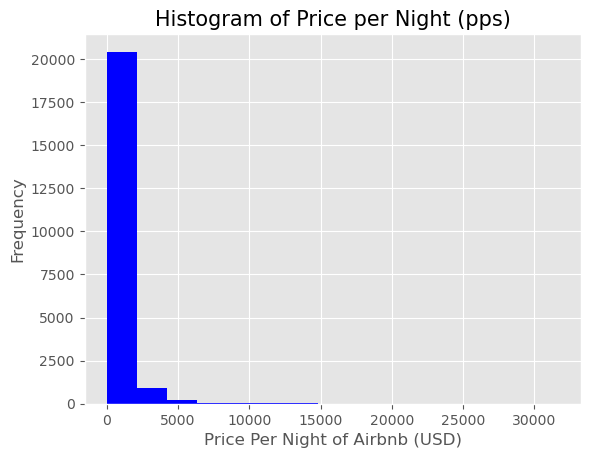

In [12]:
plt.hist((df['pps']), bins = 15, color='blue')
plt.xlabel('Price Per Night of Airbnb (USD)')
plt.ylabel('Frequency')
plt.title('Histogram of Price per Night (pps)', fontsize = 15)

Text(0.5, 1.0, 'Histogram of Log Price per Night (pps)')

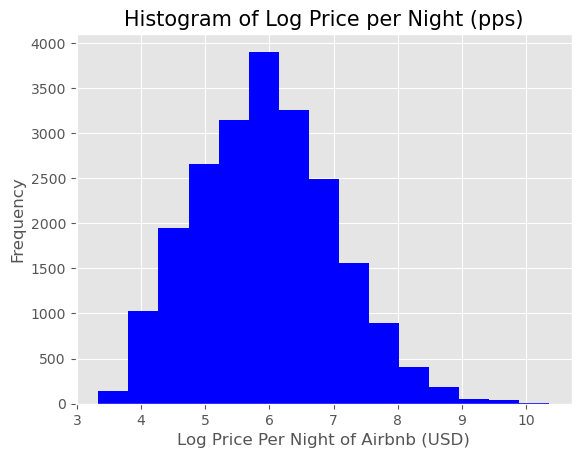

In [13]:
plt.hist((df['log_pps']), bins = 15, color='blue')
plt.xlabel('Log Price Per Night of Airbnb (USD)')
plt.ylabel('Frequency')
plt.title('Histogram of Log Price per Night (pps)', fontsize = 15)

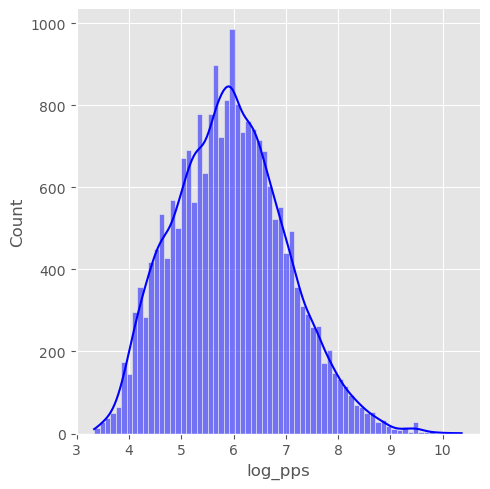

In [14]:
sns.displot((df['log_pps']), kde=True, color='blue')

array([9.24965531])

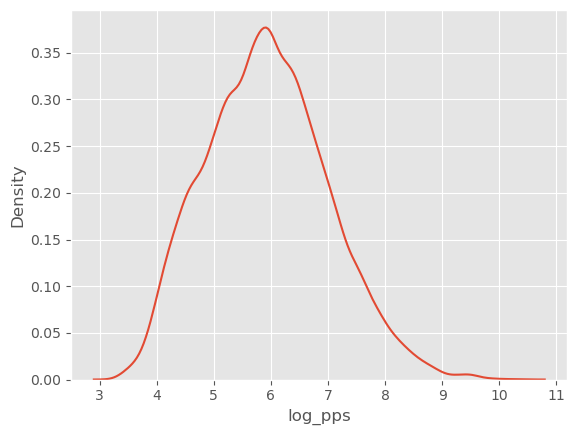

In [15]:
kde = sns.kdeplot(df['log_pps'])

kde_values = -kde.get_lines()[0].get_ydata()
minima, _ = find_peaks(kde_values)

x_values = kde.get_lines()[0].get_xdata()[minima]
x_values

Local minima: [160]


TypeError: 'AxesSubplot' object is not subscriptable

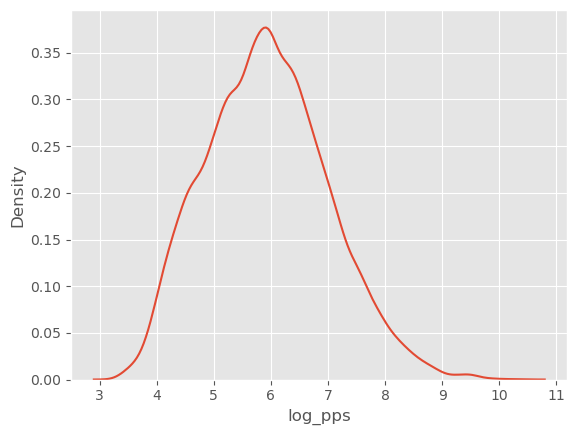

In [17]:
x_values = sns.kdeplot(df['log_pps']).get_lines()[0].get_xdata()[minima]
print('Local minima:', minima)
print('Values:', kde[minima])

In [21]:
def get_outlier_bounds(col_name):
    '''
    Gets the bound for outliers in the dataset. This is to make the visualizations easier. This function is 
    specifically for this usage and dataset
     
    Param:
        col_name: the name of the column for which you want the bounds. Must be a numerical column
    Return:
        A tuple with the col_name, upper_bound and lower_bound
    '''
    iqr = describe_df.loc['75%',col_name] - describe_df.loc['25%',col_name]
    upper_bound = describe_df.loc['75%',col_name] + (1.5* iqr)
    lower_bound = describe_df.loc['25%',col_name] - (1.5*iqr)
    print(col_name)
    print('upper bound ' + upper_bound.astype(str))
    print('lower bound ' + lower_bound.astype(str))
    print('-'*50)
    return (col_name,upper_bound,lower_bound)

In [22]:
# filtering out the outliers
# We only want the numeric columns because the get_outlier_bounds won't work on strings
numeric_cols = listingsNYC.select_dtypes(include=np.number)
for column in numeric_cols.columns:
    listingsNYC = listingsNYC[(listingsNYC[column] < get_outlier_bounds(column)[1]) & (listingsNYC[column] > get_outlier_bounds(column)[2])]
listingsNYC

,id,name,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,ppn
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Brooklyn,Sunset Park,Entire home/apt,275,21,3,0.03,1,267,1,13.10
2,5121,BlissArtsSpace!,7356,Brooklyn,Bedford-Stuyvesant,Private room,60,30,50,0.30,2,322,0,2.00
4,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,Entire home/apt,175,30,49,0.31,3,365,1,5.83
5,6872,Uptown Sanctuary w/ Private Bath (Month to Month),16104,Manhattan,East Harlem,Private room,65,30,1,0.16,2,300,1,2.17
11,7801,Sweet and Spacious Brooklyn Loft,21207,Brooklyn,Williamsburg,Entire home/apt,395,30,9,0.06,1,332,0,13.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41036,768899741442488288,this is studio apartment,488754388,Queens,Glendale,Entire home/apt,106,1,1,1.00,1,346,1,106.00
41056,768239303625460600,Apartment in Corona Queens,105692628,Queens,Jackson Heights,Entire home/apt,140,1,1,1.00,1,350,1,140.00
41066,769046532467871799,Entire 3 bedroom apt - Sunnyside,188096291,Queens,Sunnyside,Entire home/apt,130,1,1,1.00,1,355,1,130.00
41175,770593748958588679,Luxury Brooklyn apt. | 10 mins away from JFK,489532090,Brooklyn,East New York,Entire home/apt,145,1,2,2.00,1,351,2,145.00


In [ ]:
# boxplot with the x would be the _____ and the y would be ______